In [1]:
import openmc
import numpy as np
import os
import math
import matplotlib.pyplot as plt
import pandas as pd
import kdsource as kds
from mpl_toolkits.mplot3d import Axes3D as ax


In [2]:
openmc_data = "/home/agusgimenez/Desktop/Secciones/endfb-viii.0-hdf5/cross_sections.xml"
os.environ["OPENMC_CROSS_SECTIONS"] = openmc_data
openmc.config['cross_sections'] = openmc_data

In [3]:
mat01 = openmc.Material(material_id=0) #agua
mat01.add_nuclide('H1',2.000,'ao')
mat01.add_nuclide('O16',0.9976,'ao')
mat01.add_nuclide('O17',0.00035,'ao')
mat01.add_s_alpha_beta('c_H_in_H2O')
mat01.set_density('g/cm3',1.00)


mat02 = openmc.Material(material_id=1)
mat02.add_nuclide('Cd106',1.22,'ao')
mat02.add_nuclide('Cd108',0.88,'ao')
mat02.add_nuclide('Cd110',12.39,'ao')
mat02.add_nuclide('Cd111',12.75,'ao')
mat02.add_nuclide('Cd112',24.07,'ao')
mat02.add_nuclide('Cd113',12.26,'ao')
mat02.add_nuclide('Cd114',28.86,'ao')
mat02.add_nuclide('Cd116',7.58,'ao')
mat02.set_density('g/cm3',8.65)


In [4]:

#bloque mat01
W =5.0 #semi-ancho
H =5.0 #semi-alto


#bloque donde quiero ver la lista de particulas
angle = math.radians(45)
L = H/ (2 * math.tan(angle))
# #bloque mat02
# e_cd =1.0 #espesor
# w_cd =0.1 #ancho de cada bloque
# if w_cd>W/2:
#     exit

#FUENTE
R = 1.0



<Axes: xlabel='x [cm]', ylabel='z [cm]'>

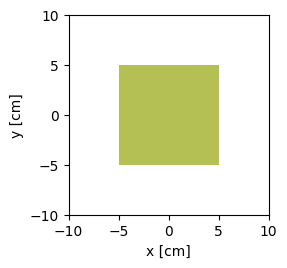

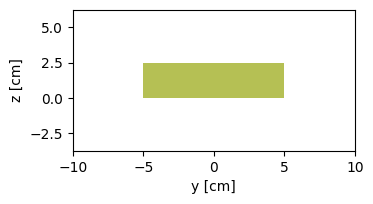

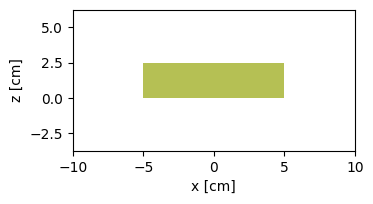

In [5]:

#bloque mat01
surf1 = openmc.XPlane(-W)
surf1.boundary_type = 'vacuum'

surf6 = openmc.XPlane(W)
surf6.boundary_type = 'vacuum'

surf2 = openmc.YPlane(-H)
surf2.boundary_type = 'vacuum'

surf5 = openmc.YPlane(H)
surf5.boundary_type = 'vacuum'


surf3 = openmc.ZPlane(0)
surf3.boundary_type = 'vacuum'

surf4 = openmc.ZPlane(L)
surf4.boundary_type = 'vacuum'






cell01 = openmc.Cell(fill=None,cell_id=1)
cell01.region = +surf1 & -surf6 & +surf2 & -surf5 & +surf3 & -surf4



univ01 = openmc.Universe(cells=[cell01],universe_id=1) 
univ01.plot(origin=(0.0,0.0,L/2),width=(4*W,4*W))
univ01.plot(origin=(0.0,0.0,L/2),width=(4*W,4*L),basis='yz')
univ01.plot(origin=(0.0,0.0,L/2),width=(4*W,4*L),basis='xz')








In [6]:
S = openmc.Source()
S.particle = 'neutron'
#dist_espacial'

r = openmc.stats.PowerLaw(0.0,R,1.0)
phi = openmc.stats.Uniform(0.0 , 2*math.pi)
z = openmc.stats.Discrete(0.0 , 1.0)
S.space = openmc.stats.CylindricalIndependent(r,phi,z)

#dist_Energia
S.energy = openmc.stats.Discrete(30.0,1.0)

#dist_angular.

S.angle = openmc.stats.Monodirectional(reference_uvw=[0.0,0.0,1.0])

/home/agusgimenez/anaconda3/envs/openmc_develop/lib/python3.9/site-packages/openmc/source.py:390: FutureWarning: This class is deprecated in favor of 'IndependentSource'
  warnings.warn("This class is deprecated in favor of 'IndependentSource'", FutureWarning)


In [7]:
S2 = openmc.Source()
S2.particle = 'neutron'
#dist_espacial'

r = openmc.stats.PowerLaw(0.0,R,1.0)
phi = openmc.stats.Uniform(0.0 , 2*math.pi)
z = openmc.stats.Discrete(0.0 , 1.0)
S2.space = openmc.stats.CylindricalIndependent(r,phi,z)

#dist_Energia
S2.energy = openmc.stats.Discrete(30.0,1.0)

#dist_angular.

# S2.angle = openmc.stats.Monodirectional(reference_uvw=[0.0,math.cos(math.pi-angle),math.cos(angle)])
S2.angle = openmc.stats.Monodirectional(reference_uvw=[0.0,1,0])

In [8]:
tallies = openmc.Tallies()


#FILTRO PARTICULA
Filtro_particula_neutron    =   openmc.ParticleFilter(['neutron'],filter_id = 0)


#FILTRO SUPERFICIE CHECK SOURCE
Filtro_surface_source       =   openmc.SurfaceFilter(surf4.id,filter_id=1)


dist_surface_source = openmc.Tally(name='check_source', tally_id=7)
dist_surface_source.scores = ["current"]
dist_surface_source.filters = [Filtro_surface_source,Filtro_particula_neutron]
tallies.append(dist_surface_source)

In [9]:
#Numero de particulas 
N = int(1E6)

param = openmc.Settings()
param.source = S
param.run_mode = "fixed source"
param.batches = 1
param.particles = N

In [10]:


geom = openmc.Geometry(univ01)
geom.export_to_xml()

mats = openmc.Materials(univ01.get_all_materials().values())
mats.cross_sections = openmc_data
mats.export_to_xml()


param.export_to_xml()

tallies.export_to_xml()


In [11]:
!rm statepoint.*.h5
!rm summary.h5
openmc.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

In [12]:
sp = openmc.StatePoint("statepoint.1.h5")
A = sp.get_tally(name='check_source')
J1 = A.get_pandas_dataframe()

/home/agusgimenez/anaconda3/envs/openmc_develop/lib/python3.9/site-packages/openmc/tallies.py:391: RuntimeWarning: invalid value encountered in divide
  self._std_dev[nonzero] = np.sqrt((self.sum_sq[nonzero]/n -


In [13]:
!rm tallies.xml settings.xml

In [14]:
#Numero de particulas 
N = int(1E6)

param = openmc.Settings()
param.source = S2
param.run_mode = "fixed source"
param.batches = 1
param.particles = 1
param.export_to_xml()

In [15]:
tallies_1 = openmc.Tallies()

dist_surface_source_1 = openmc.Tally(name='check_source_1', tally_id=8)
dist_surface_source_1.scores = ["current"]
dist_surface_source_1.filters = [Filtro_surface_source,Filtro_particula_neutron]
tallies_1.append(dist_surface_source_1)
tallies_1.export_to_xml()

In [16]:
!rm statepoint.*.h5
!rm summary.h5
openmc.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

In [18]:
sp2 = openmc.StatePoint("statepoint.1.h5")
B = sp.get_tally(name='check_source')
J2 = A.get_pandas_dataframe()

In [19]:
J1

,surface,particle,nuclide,score,mean
0,6,neutron,total,current,1.0


In [20]:
J2

,surface,particle,nuclide,score,mean
0,6,neutron,total,current,1.0
